In [1]:
import numpy as np
from scipy import stats
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from sklearn import preprocessing

In [2]:
def inverse_sample_decorator(dist):
    def wrapper(pnts, x_min, x_max, nbins, n=1e5, **kwargs):
        x = np.linspace(x_min, x_max, int(n))
        cumulative = np.cumsum(dist(x, **kwargs))
        r_x = x * (13**0.5)
        #print(x.min(),x.max())
        scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
        cumulative = scaler.fit_transform(cumulative.reshape(-1, 1))
        cumulative = cumulative.reshape(int(n))
        #plt.scatter(r_x, cumulative, label="CDF")
        cdf = interp1d(r_x, cumulative)
        bins = np.linspace(1,7,nbins+1)
        #print(bins)
        cdf_bins = cdf(bins)[1:] - cdf(bins)[:-1]
        #plt.scatter(cumulative, r_x, label="iCDF")
        #plt.legend()
        plt.show()
        real_low = (cumulative).min()
        real_high = (cumulative).max()
        #print((cumulative/cumulative.max()).max(),(cumulative/cumulative.max()).min())
        ff = interp1d(cumulative, x)
        return ff(np.random.uniform(low=real_low, high=real_high, size=pnts)), cdf_bins 
    return wrapper

In [3]:
# Experimenting with Eq2
@inverse_sample_decorator
def f(x,ts=[1.1,1.2,1.3,1.4],nbins=60):
    xx = x/(13)**0.5
    v = ts[0] * ((1-xx)**(ts[1])) * (xx**ts[2]) * (xx**(ts[3]*np.log(xx)))
    return v

In [195]:
NBINS = 60
NE = 100000  # number of events per parametric
NP = 10000   # number of different parametrics

In [5]:
def data_gen(pmin, pmax, na, nb, f, nbins=60, scaled=False):
    init = True
    for i in range(nb):
        samples, y = f(na,ts=np.random.uniform(low=pmin,high=pmax,size=4), nbins=60,
                                            x_min=1/(13**0.5),x_max=7/(13**0.5))
        samples *= (13**0.5)
        
        plt.style.use("dark_background")
        #(n, bins, patches) = plt.hist(samples, log=True, bins=nbins, 
        #                                 label="data", histtype="step")
        n, bins = np.histogram(samples, bins=nbins)
        #plt.scatter(binss[:nbins],n)
            
        if scaled:
            scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
            n = scaler.fit_transform(n.reshape(-1, 1))
            n = n.reshape(nbins)
            
        if init:
            X = np.array(n)
            Y = np.array(y)
            binsc = 0.5*(bins[1:] + bins[:-1]) 
            init = False

        else:
            X = np.vstack((X,n))
            Y = np.vstack((Y,y))
            
    plt.show()
    return X,Y,binsc

In [10]:
GEN = False
import h5py
if GEN:
    X,Y,binsc= data_gen(1.2,1.8,100000,10000,f,scaled=True)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    Y = Y.reshape(Y.shape[0], Y.shape[1], 1)

    hf = h5py.File("bg-parametric.h5","w")
    hf.create_dataset("sample", data=X)
    hf.create_dataset("bin prob", data=Y)
    hf.close()
else:
    hf = h5py.File("bg-parametric.h5","r")
    X = np.array(hf.get("sample"))
    Y = np.array(hf.get("bin prob"))
    
    bins = np.linspace(1,7,nbins+1)
    binsc = 0.5*(bins[1:] + bins[:-1]) 
    
print(X.shape, Y.shape)

(10000, 60, 1) (10000, 60, 1)


In [208]:
def prob2event(x):
    x = np.array(x)
    x.reshape(NBINS)
    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    x = (x * NE) 
    x = scaler.fit_transform(x.reshape(-1,1))
    x = x.reshape(NBINS)
    return x

In [206]:
def plot1(X, Y):
    plt.style.use("dark_background")
    plt.grid()
    plt.yscale("log")
    plt.ylim((10**-4,10**0))
    plt.xlabel("m[TeV]")
    plt.ylabel("Events per bin")
    plt.scatter(binsc,X, s=6, label="sample")
    plt.scatter(binsc,prob2event(Y), s=6, label="bin prob")
    plt.legend()
    plt.show()

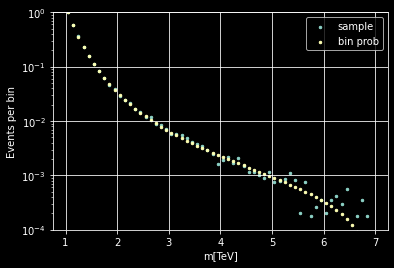

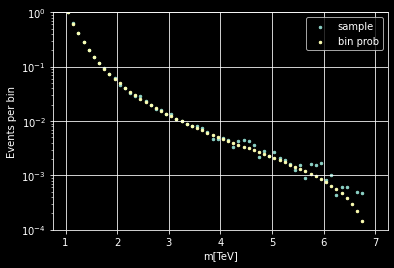

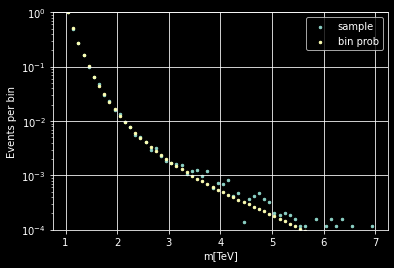

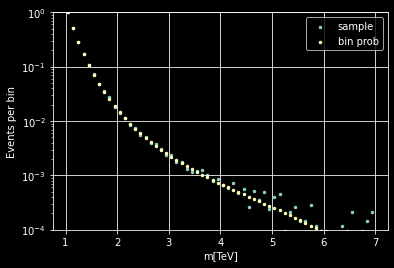

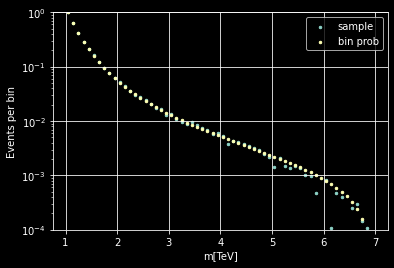

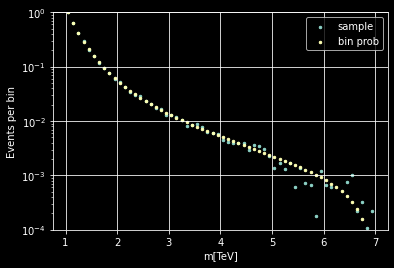

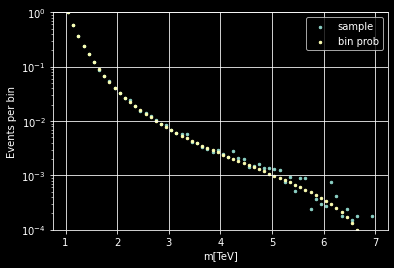

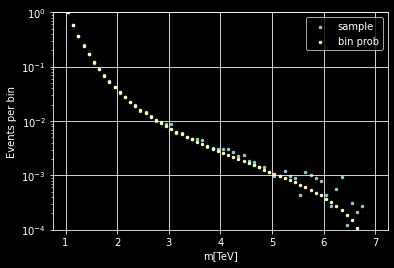

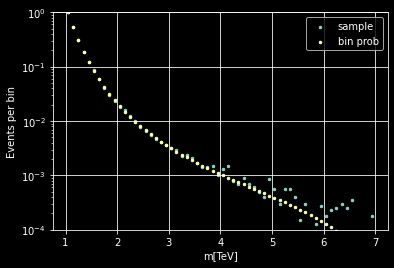

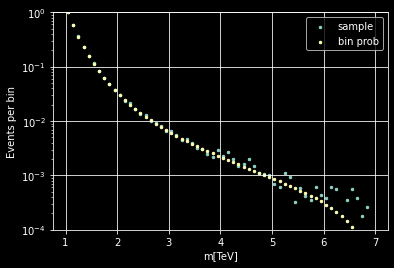

In [207]:
for i in np.random.randint(NP, size=10):
    plot1(X[i,:], Y[i,:])

In [13]:
import tensorflow.keras as keras
import tensorflow as tf

In [14]:
# Try LSTM s2s
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.

In [15]:
Y_shifted = np.roll(Y,1)

In [16]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, 1))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, 1))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(1, activation="linear")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [17]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                           patience=25, verbose=0,
                                           mode='auto', baseline=None,
                                           restore_best_weights=True)]

In [18]:
model.compile(
    optimizer="adam", loss="mse"
)
model.fit(
    [X, Y_shifted],
    Y,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=callbacks
)
# Save model
model.save("s2s")

Epoch 1/100
125/125 [==============================] - 2s 14ms/step - loss: 3.1270e-04 - val_loss: 6.9011e-05
Epoch 2/100
125/125 [==============================] - 1s 9ms/step - loss: 6.7894e-05 - val_loss: 6.6975e-05
Epoch 3/100
125/125 [==============================] - 1s 9ms/step - loss: 6.3408e-05 - val_loss: 5.9544e-05
Epoch 4/100
125/125 [==============================] - 1s 9ms/step - loss: 1.2452e-05 - val_loss: 9.6083e-07
Epoch 5/100
125/125 [==============================] - 1s 9ms/step - loss: 9.6953e-07 - val_loss: 1.5574e-06
Epoch 6/100
125/125 [==============================] - 1s 10ms/step - loss: 7.2504e-07 - val_loss: 3.9251e-07
Epoch 7/100
125/125 [==============================] - 1s 10ms/step - loss: 7.9691e-07 - val_loss: 3.3766e-07
Epoch 8/100
125/125 [==============================] - 1s 9ms/step - loss: 6.4251e-07 - val_loss: 3.4549e-06
Epoch 9/100
125/125 [==============================] - 1s 9ms/step - loss: 6.3858e-07 - val_loss: 5.1822e-07
Epoch 10/100
125

In [19]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_5")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_6")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

In [209]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, 0] = 0.5

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_dist = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_char = output_tokens[0,0,0]
        #print(sampled_char)
        decoded_dist.append(sampled_char)

        # Exit condition: either hit max length
        # or find stop character.
        if len(decoded_dist) == 60:
        #if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = sampled_char

        # Update states
        states_value = [h, c]
    return decoded_dist

In [235]:
def test1(lowp, highp, ne=NE, plot=True):
    X_test,Y_test,binsc= data_gen(lowp,highp,ne,1,f,scaled=True)
    X_test = X_test.reshape(1, X_test.shape[0], 1)
    Y_test = Y_test.reshape(1, Y_test.shape[0], 1)

    Y_hat = decode_sequence(X_test)
    print(sum(Y_hat))

    if plot:
        plt.grid()
        plt.ylim((10**-4,10**0))
        plt.yscale("log")
        plt.scatter(binsc,X_test, s=6, label="sample")
        plt.scatter(binsc, prob2event(Y_test), s=6, label="true bin prob")
        plt.scatter(binsc, prob2event(Y_hat), s=6, label="predict bin prob", c="red")
        plt.xlabel("m[TeV]")
        plt.ylabel("Events per bin")
        plt.title("Test on parametric ({},{})".format(lowp, highp))
        plt.legend()
        plt.show()
    return X_test, Y_test, Y_hat

1.3106211833655834


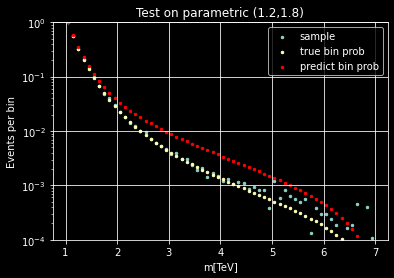

1.2100887219421566


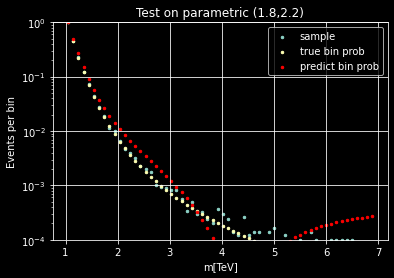

1.3066867096349597


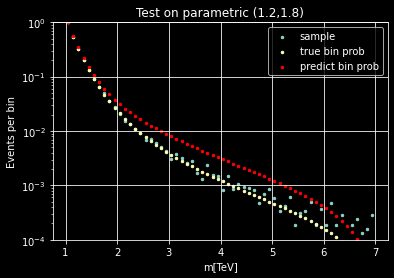

1.2819935902953148


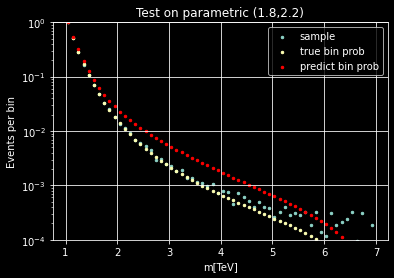

1.3162808627821505


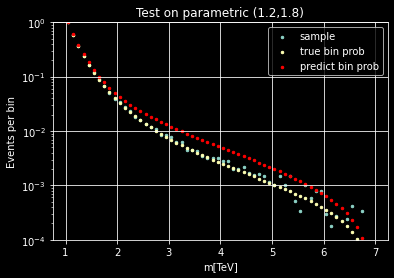

1.26940998993814


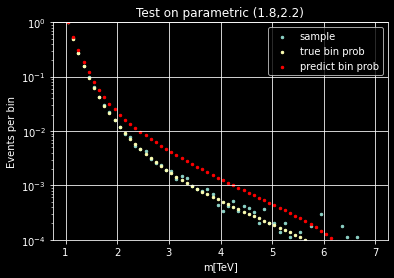

1.27200582716614


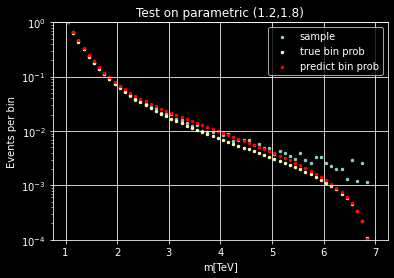

1.223864636849612


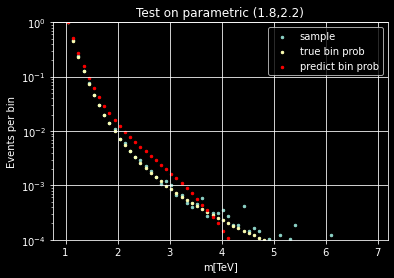

1.316016283351928


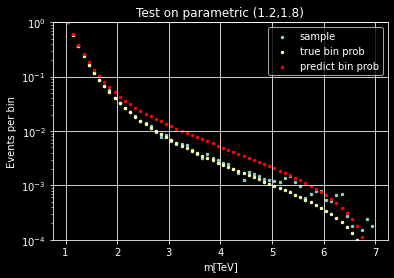

1.267360469326377


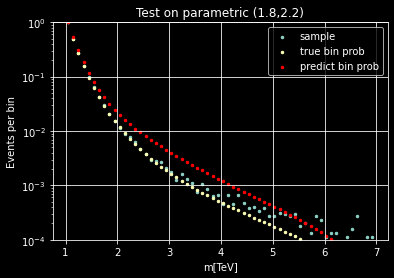

1.3154882644303143


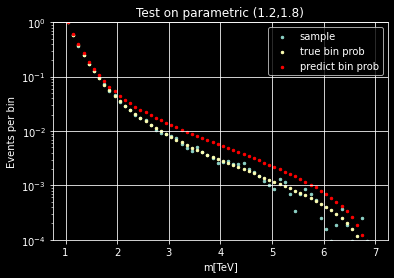

1.240608086809516


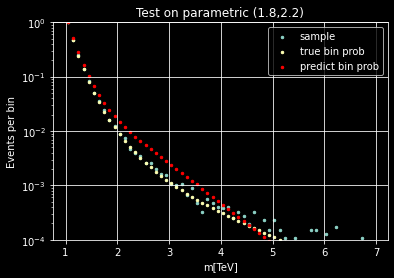

1.2737589930184186


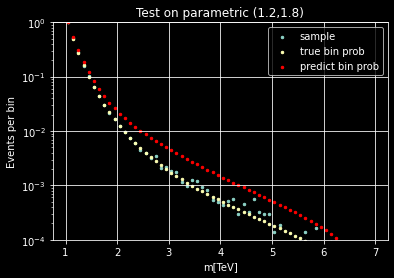

1.274106225464493


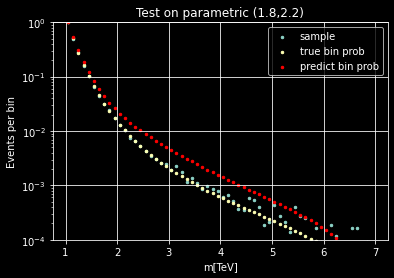

1.3147415267303586


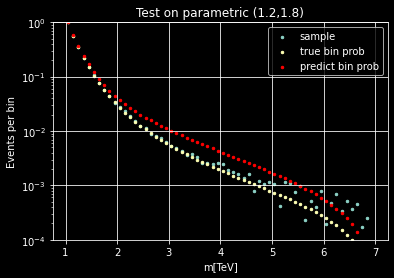

1.251664967276156


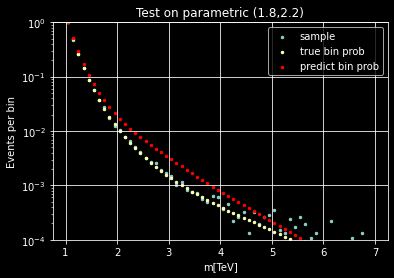

1.3151326109655201


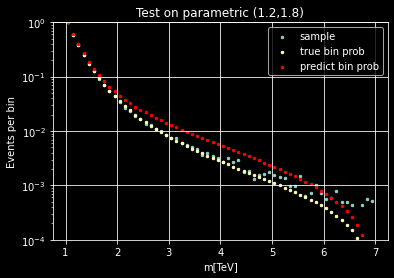

1.2351442947983742


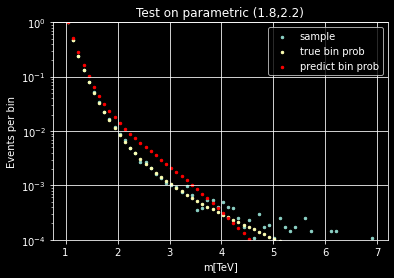

1.2940228790976107


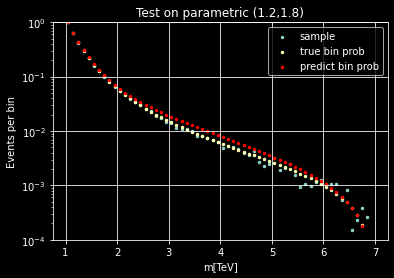

1.2011659517884254


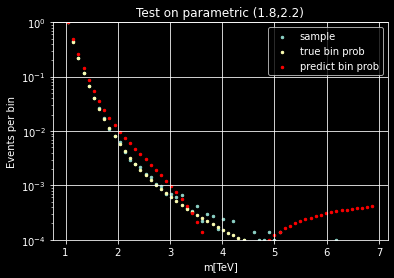

In [224]:
for i in range(10):
    test1(1.2,1.8)
    test1(1.8,2.2)

In [254]:
def probs2events(X):
    X = X.reshape(NP, NBINS)
    res = np.zeros((NP, NBINS))
    for i in range(X.shape[0]):
        x = X[i]
        x.reshape(NBINS)
        scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
        x = (x * NE) 
        x = scaler.fit_transform(x.reshape(-1,1))
        x = x.reshape(NBINS)
        res[i] = x
    return res

In [ ]:
peY = probs2events(Y)

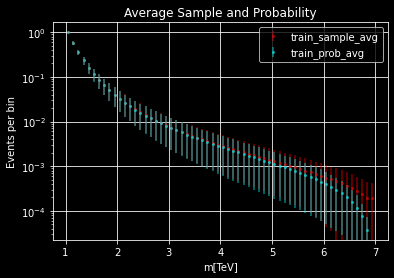

In [266]:
pX = X.reshape(X.shape[0], X.shape[1])
pY = Y.reshape(Y.shape[0], Y.shape[1])

X_avg = np.average(pX, axis=0)
X_var = np.std(pX, axis=0)

Y_avg = np.average(peY, axis=0)
Y_var = np.std(peY, axis=0)

plt.yscale("log")
plt.errorbar(binsc, X_avg, yerr=X_var, fmt='o',markersize=2, label="train_sample_avg", alpha=0.5, color="red")
plt.errorbar(binsc, Y_avg, yerr=Y_var, fmt='o',markersize=2, label="train_prob_avg", alpha=0.5, color="cyan")
plt.grid()
plt.xlabel("m[TeV]")
plt.ylabel("Events per bin")
plt.title("Average Sample and Probability")
plt.legend()
plt.show()

In [237]:
X_test, Y_test, Y_hat = test1(1.2, 1.8, plot=False)

1.2678207629360259


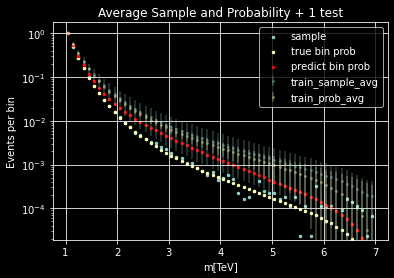

In [239]:
pX = X.reshape(X.shape[0], X.shape[1])
pY = Y.reshape(Y.shape[0], Y.shape[1])

X_avg = np.average(pX, axis=0)
X_var = np.std(pX, axis=0)

Y_avg = np.average(pY, axis=0)
Y_var = np.std(pY, axis=0)

plt.yscale("log")
plt.errorbar(binsc, X_avg, yerr=X_var, fmt='o',markersize=2, label="train_sample_avg",alpha=0.3)
plt.errorbar(binsc, prob2event(Y_avg), yerr=Y_var, fmt='o',markersize=2, label="train_prob_avg",alpha=0.3)
plt.scatter(binsc,X_test, s=6, label="sample")
plt.scatter(binsc, prob2event(Y_test), s=6, label="true bin prob")
plt.scatter(binsc, prob2event(Y_hat), s=6, label="predict bin prob", c="red")
plt.grid()
plt.xlabel("m[TeV]")
plt.ylabel("Events per bin")
plt.title("Average Sample and Probability + 1 test")
plt.legend()
plt.show()

## Compare with simple Dense Network

In [ ]:
def create_model(inx):
    # Create the model 
    model = keras.Sequential()
    model.add(keras.layers.Dense(units = 16, activation = 'linear', input_shape=[inx]))
    model.add(keras.layers.Dense(units = 64, activation = 'relu', kernel_regularizer='l1'))
    model.add(keras.layers.Dense(units = 128, activation = 'relu', kernel_regularizer='l1'))
    model.add(keras.layers.Dense(units = 128, activation = 'relu', kernel_regularizer='l1'))
    model.add(keras.layers.Dense(units = 64, activation = 'relu', kernel_regularizer='l1'))
    model.add(keras.layers.Dense(units = inx, activation = 'linear'))
    model.compile(loss='mse', optimizer="adam")

    # Display the model
    model.summary()

    return model

In [114]:
model_dnn = create_model(60)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 16)                976       
_________________________________________________________________
dense_14 (Dense)             (None, 64)                1088      
_________________________________________________________________
dense_15 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_18 (Dense)             (None, 60)                3900      
Total params: 39,052
Trainable params: 39,052
Non-trainable params: 0
__________________________________________________

In [115]:
callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, 
                                           patience=15, verbose=0,
                                           mode='auto', baseline=None,
                                           restore_best_weights=True)]

In [116]:
model_dnn.fit(pX, pY, epochs=100, verbose=1, batch_size=32, callbacks=callbacks)

Epoch 1/100
313/313 [==============================] - 1s 2ms/step - loss: 5.3145
Epoch 2/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0430
Epoch 3/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0430
Epoch 4/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0430
Epoch 5/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0430
Epoch 6/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0430
Epoch 7/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0430
Epoch 8/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0430
Epoch 9/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0430
Epoch 10/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0430
Epoch 11/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0430
Epoch 12/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0430
Epoch 13/100


In [117]:
y_hat_dnn = model_dnn.predict(X_test.reshape(1,60))

In [247]:
def test1vsDNN(lowp, highp, ne=NE, plot=True):
    X_test,Y_test,binsc= data_gen(lowp,highp,ne,1,f,scaled=True)
    X_test = X_test.reshape(1, X_test.shape[0], 1)
    Y_test = Y_test.reshape(1, Y_test.shape[0], 1)

    Y_hat = decode_sequence(X_test)
    Y_hat_dnn = model_dnn.predict(X_test.reshape(1,60)).reshape(NBINS)
    print(sum(Y_hat), np.sum(Y_hat_dnn))

    if plot:
        plt.grid()
        plt.ylim((10**-4,10**0))
        plt.yscale("log")
        plt.scatter(binsc,X_test, s=6, label="sample")
        plt.scatter(binsc, prob2event(Y_test), s=6, label="true bin prob")
        plt.scatter(binsc, prob2event(Y_hat), s=6, label="predict bin prob", c="red")
        plt.scatter(binsc, prob2event(Y_hat_dnn), s=6, label="predict bin prob", c="white")
        plt.xlabel("m[TeV]")
        plt.ylabel("Events per bin")
        plt.title("LSTM vs DNN Test on parametric ({},{})".format(lowp, highp))
        plt.legend()
        plt.show()
    return X_test, Y_test, Y_hat

1.3002421138808131 1.0136001


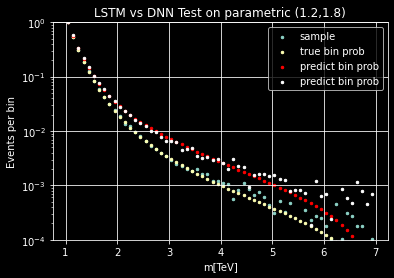

1.295016035437584 1.0136001


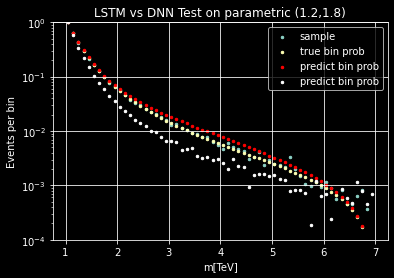

1.3144023716449738 1.0136001


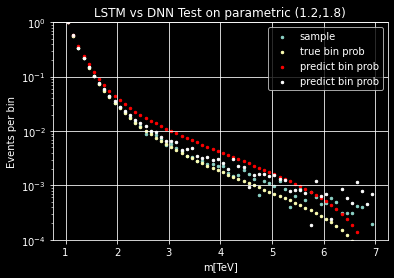

1.3132237689569592 1.0136001


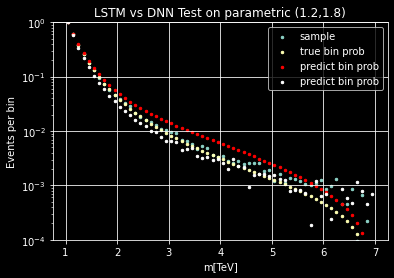

1.3145981784909964 1.0136001


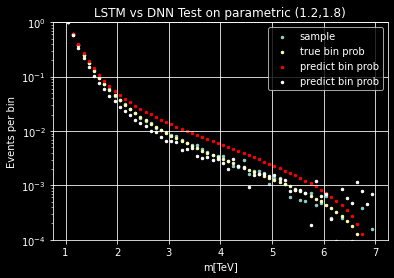

1.2952733300626278 1.0136001


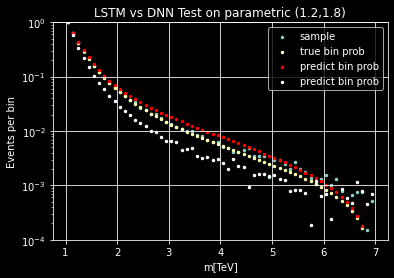

1.3163955211639404 1.0136001


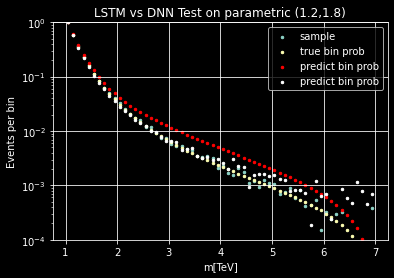

1.3162598735652864 1.0136001


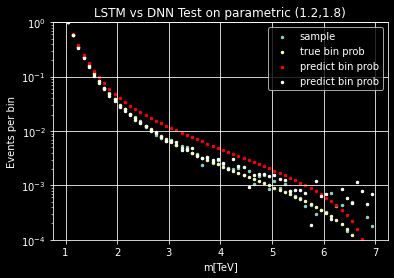

1.273444201797247 1.0136001


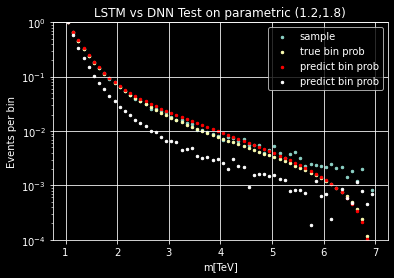

1.312673692125827 1.0136001


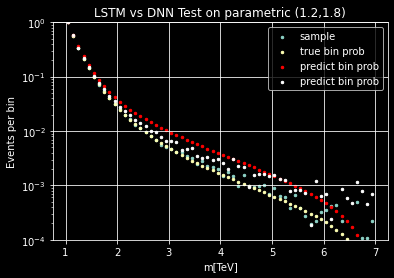

In [250]:
for i in range(10):
    _ = test1vsDNN(1.2, 1.8)